In [1]:
%matplotlib inline

# Regularization 

Below are some examples in PyTorch for regularization. 

YES, there are many ways to do it, these are just a few examples. 

Lets first do no regularization.

Training Epoch: 100%|██████████| 1500/1500 [00:17<00:00, 87.89it/s]


Done learning


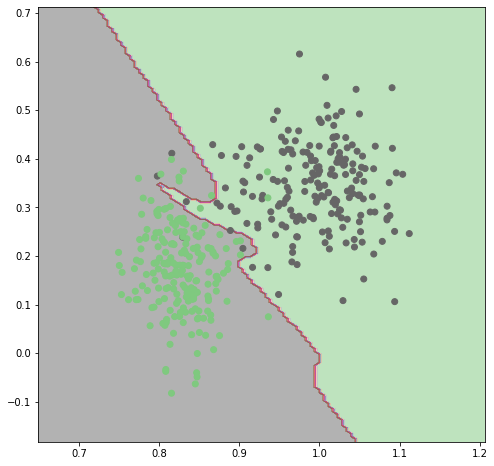

In [5]:
import torch
from tqdm import tqdm
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from scipy.linalg import lstsq
import sys
import argparse
from torchvision import datasets
import torch.nn as nn

##############################################
# this is our class (look in local directory) for making a PyTorch "dataset" for minibatch
##############################################

from dataset_utils2 import Format_Dataset

##############################################
# lets define our neural network
##############################################

class MyMLP(torch.nn.Module):

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

    def __init__(self, D_in, H1, H2, D_out):
        super(MyMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.Tanh(),
            nn.Linear(H1,H2),
            nn.Sigmoid(),            
            nn.Linear(H2, D_out),
            nn.Sigmoid()
        )  
        
##############################################
# lets use a random seed so we can get deterministic results run-2-run
##############################################

torch.manual_seed(3527)

##############################################
# dataset
##############################################

# data -----------------------------------
NoSamples = 400
NoPatterns = 2 
x = torch.zeros(NoSamples,2)

# labels ---------------------------------
l = torch.zeros(NoSamples,2)
l[0:int(NoSamples/2),0] = 1.0
l[int(NoSamples/2):,1] = 1.0

# randomly pick our data
Membs = torch.rand(NoPatterns,2) # the means 
Stds = torch.rand(NoPatterns,2)*.1 # the standard deviations 
dc = 0
for r in range(NoPatterns):
    tm = torch.Tensor([Membs[r,0], Membs[r,1]]) 
    tc = torch.eye(2)
    tc[0,0] = Stds[r,0]*Stds[r,0]
    tc[1,1] = Stds[r,1]*Stds[r,1]
    m = torch.distributions.multivariate_normal.MultivariateNormal(tm,tc)
    for i in range(int(NoSamples/NoPatterns)):
        x[dc,:] = m.sample()
        dc = dc + 1

##############################################
# convert this into our PyTorch dataset object
##############################################

# make up training data set
dataset = {'samples': x, 'labels': l} 
train = Format_Dataset(dataset, choice = 'Train')
train = torch.utils.data.DataLoader( shuffle = False,
                                        dataset = train, 
                                        batch_size = 30 ) # here is our mini-batch size

##############################################
# create a network and set up optimization
##############################################

D_in, H1, H2, D_out = 2, 32, 32, 2                                              
net = MyMLP(D_in, H1, H2, D_out)

#criterion = torch.nn.BCELoss()
#def criterion(out,label):
#    return (label - out)**2
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

##############################################
# learning
##############################################

NoEpochs = 1500
for epoch in tqdm(range( NoEpochs ),'Training Epoch'):
    for sample, label in train:
        outputs = net(sample)             # this passes in a set of data
        loss = criterion(outputs, label)  # forward pass on set of data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            
print('Done learning')

##############################################
# draw
##############################################

x_min, x_max = x[:, 0].min()-0.1, x[:, 0].max()+0.1
y_min, y_max = x[:, 1].min()-0.1, x[:, 1].max()+0.1
spacing = min(x_max - x_min, y_max - y_min) / 100
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
            np.arange(y_min, y_max, spacing))
datax = np.hstack((XX.ravel().reshape(-1,1), 
                YY.ravel().reshape(-1,1)))
data_t = torch.FloatTensor(datax)
db_prob = net(data_t)
db_vals, clf = torch.max(db_prob, 1)
Z = clf.reshape(XX.shape)
plt.figure(figsize=(8,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
L = np.zeros(NoSamples)
L[0:int(NoSamples/2)] = 1.0
plt.scatter(x[:,0], x[:,1], c=L, cmap=plt.cm.Accent)
plt.show()

Now, let's add some regularization 

Training Epoch: 100%|██████████| 1500/1500 [00:23<00:00, 62.51it/s]


Done learning


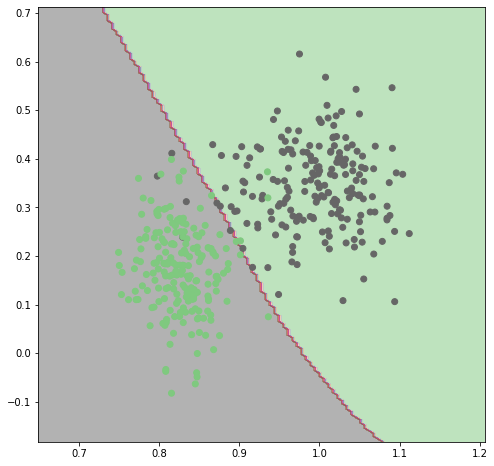

In [6]:
import torch
from tqdm import tqdm
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from scipy.linalg import lstsq
import sys
import argparse
from torchvision import datasets
import torch.nn as nn
from torch.autograd import Variable

##############################################
# this is our class (look in local directory) for making a PyTorch "dataset" for minibatch
##############################################

from dataset_utils2 import Format_Dataset

##############################################
# lets define our neural network
##############################################

class MyMLP(torch.nn.Module):

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

    def __init__(self, D_in, H1, H2, D_out):
        super(MyMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.Tanh(),
            nn.Linear(H1,H2),
            nn.Sigmoid(),            
            nn.Linear(H2, D_out),
            nn.Sigmoid()
        )  
        
##############################################
# lets use a random seed so we can get deterministic results run-2-run
##############################################

torch.manual_seed(3527)

##############################################
# dataset
##############################################

# data -----------------------------------
NoSamples = 400
NoPatterns = 2 
x = torch.zeros(NoSamples,2)

# labels ---------------------------------
l = torch.zeros(NoSamples,2)
l[0:int(NoSamples/2),0] = 1.0
l[int(NoSamples/2):,1] = 1.0

# randomly pick our data
Membs = torch.rand(NoPatterns,2) # the means 
Stds = torch.rand(NoPatterns,2)*.1 # the standard deviations 
dc = 0
for r in range(NoPatterns):
    tm = torch.Tensor([Membs[r,0], Membs[r,1]]) 
    tc = torch.eye(2)
    tc[0,0] = Stds[r,0]*Stds[r,0]
    tc[1,1] = Stds[r,1]*Stds[r,1]
    m = torch.distributions.multivariate_normal.MultivariateNormal(tm,tc)
    for i in range(int(NoSamples/NoPatterns)):
        x[dc,:] = m.sample()
        dc = dc + 1

##############################################
# convert this into our PyTorch dataset object
##############################################

# make up training data set
dataset = {'samples': x, 'labels': l} 
train = Format_Dataset(dataset, choice = 'Train')
train = torch.utils.data.DataLoader( shuffle = False,
                                        dataset = train, 
                                        batch_size = 30 ) # here is our mini-batch size

##############################################
# create a network and set up optimization
##############################################

D_in, H1, H2, D_out = 2, 32, 32, 2                                              
net = MyMLP(D_in, H1, H2, D_out)

#criterion = torch.nn.BCELoss()
#def criterion(out,label):
#    return (label - out)**2
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

##############################################
# learning
##############################################

NoEpochs = 1500
for epoch in tqdm(range( NoEpochs ),'Training Epoch'):
    for sample, label in train:
        outputs = net(sample)             # this passes in a set of data
        loss = criterion(outputs, label)  # forward pass on set of data
        optimizer.zero_grad()
        
        ##############################################
        # ********************************************
        # ********************************************
        # ********************************************
        # ********************************************
        # ********************************************
        ##############################################         
        # our regularization 
        
        if(1):
            
            lambda_l1 = 0.000001 # our reg weight
        
            l1 = Variable( torch.FloatTensor(1), requires_grad=True )
            for p in net.parameters():
                l1 = l1 + p.norm(1) # parameter is the norm degree
            loss = loss + lambda_l1 * l1
                
        ##############################################
        # ********************************************
        # ********************************************
        # ********************************************
        # ********************************************
        # ********************************************
        ##############################################           
        
        loss.backward()
        optimizer.step()            
print('Done learning')

##############################################
# draw
##############################################

x_min, x_max = x[:, 0].min()-0.1, x[:, 0].max()+0.1
y_min, y_max = x[:, 1].min()-0.1, x[:, 1].max()+0.1
spacing = min(x_max - x_min, y_max - y_min) / 100
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
            np.arange(y_min, y_max, spacing))
datax = np.hstack((XX.ravel().reshape(-1,1), 
                YY.ravel().reshape(-1,1)))
data_t = torch.FloatTensor(datax)
db_prob = net(data_t)
db_vals, clf = torch.max(db_prob, 1)
Z = clf.reshape(XX.shape)
plt.figure(figsize=(8,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
L = np.zeros(NoSamples)
L[0:int(NoSamples/2)] = 1.0
plt.scatter(x[:,0], x[:,1], c=L, cmap=plt.cm.Accent)
plt.show()